In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [61]:
#Create replacaments to assing classes to the raw data

ring_replacements = {
  r'.*_31.*': '1mm',
  r'.*bulk.*': 'bulk_soil'
}

plant_replacements = {
  r'.*BALDY.*': 'BALDY',
  r'.*BARLEYWT.*': 'BARLEYWT',
  r'.*GALVEZ_TALL.*': 'GALVEZ_TALL',
  r'.*KAUZ_DWARF.*': 'KAUZ_DWARF',
  r'.*NESSER_DWARF.*': 'NESSER_DWARF',
  r'.*W1_.*': 'W1_',
  r'.*W16_.*': 'W16_',
  r'.*SERI_TALL.*': 'SERI_TALL',
  r'.*SERI_DWARF.*': 'SERI_DWARF',
  r'.*GALVEZ_TALL.*': 'GALVEZ_TALL',
  r'.*PAVON_DWARF.*': 'PAVON_DWARF',
}

species_replacements = {
  r'.*BALDY.*': 'BALDY',
  r'.*BARLEYWT.*': 'BARLEYWT',
  r'.*GALVEZ_TALL.*': 'WHEAT',
  r'.*KAUZ_DWARF.*': 'WHEAT',
  r'.*NESSER_DWARF.*': 'WHEAT',
  r'.*W1_.*': 'WHEAT',
  r'.*W16_.*': 'WHEAT',
  r'.*SERI_TALL.*': 'WHEAT',
  r'.*SERI_DWARF.*': 'WHEAT',
  r'.*GALVEZ_TALL.*': 'WHEAT',
  r'.*PAVON_DWARF.*': 'WHEAT',
}



def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

#This function is like really slow ? Is it a Pandas issue ? mutate(ring=case_when(str_detect(filename) is what I used in R
#It is defs iterating very badly 
def add_plant_info(df):
    df = pd.DataFrame(df)
    df['ring'] = df.filename.replace(ring_replacements, regex=True)
    df.loc[df['ring'].str.contains('\.'), 'ring'] = 'other'
    #Assing Plant Values
    df['plant'] = df.filename.replace(plant_replacements, regex=True)
    df.loc[df['plant'].str.contains('\.'), 'plant'] = 'other'
    #Assing Species Values
    df['species'] = df.filename.replace(species_replacements, regex=True)
    df.loc[df['species'].str.contains('\.'), 'species'] = 'other'
    return df

#This is a quick hack on the above funstion (each data frame is per a plant so just take first row for labelling)
def add_plant_info_quick(df):
    dx = pd.DataFrame(df)
    dx=pd.DataFrame(dx.iloc[:1])
    dx['ring'] = dx.filename.replace(ring_replacements, regex=True)
    dx.loc[dx['ring'].str.contains('\.'), 'ring'] = 'other'
    #Assing Plant Values
    dx['plant'] = dx.filename.replace(plant_replacements, regex=True)
    dx.loc[dx['plant'].str.contains('\.'), 'plant'] = 'other'
    #Assing Species Values
    dx['species'] = dx.filename.replace(species_replacements, regex=True)
    dx.loc[dx['species'].str.contains('\.'), 'species'] = 'other'
    df = pd.DataFrame(df)
    df['plant']=(dx['plant']).iloc[0]
    df['species']=(dx['species']).iloc[0]
    df['ring']=(dx['ring']).iloc[0]
    return df



In [62]:
os.chdir('G:\\SOIL_UCT\\DATA_ANALYSIS\\')
pore_output_path="G:\\SOIL_UCT\\OUT_PORE\\"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(pore_output_path)
                 for file in glob(os.path.join(path, EXT))]
csv_names=pd.DataFrame(all_csv_files)
csv_names.columns = ['csv_text_id']

In [63]:
# Pore Regions 
region_data_string=str("region")
region_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(region_data_string)]

region_df = []

for index, row in region_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info_quick(df_i)
    region_df.append(df_i)
    
region_df = pd.concat(region_df)
region_df.rename(columns={'0':'region_volume'}, inplace=True)
region_df.rename(columns={'Unnamed: 0':'region_id'}, inplace=True)



In [65]:
# Pore Regions in First Ring - Wrangle 
region_df_agg = region_df.groupby(['IMAGE_ID', "plant", "species","ring"], 
                                            as_index=False).agg(pore_volume=('region_volume','sum'), 
                                            pore_count= ('region_volume','count'),
                                            average_region_size=('region_volume','mean'))


In [66]:
region_df_agg_table = region_df.groupby(["species","ring"], 
                                            as_index=False).agg(pore_volume=('region_volume','sum'), 
                                            pore_count= ('region_volume','count'),
                                            average_region_size=('region_volume','mean'))
region_df_agg_table


,species,ring,pore_volume,pore_count,average_region_size
0,BALDY,1mm,3.808877e+11,15986,2.382633e+07
1,BALDY,bulk_soil,3.041760e+12,121388,2.505816e+07
2,BARLEYWT,1mm,2.933770e+11,12710,2.308238e+07
3,BARLEYWT,bulk_soil,3.360072e+12,144101,2.331748e+07
4,WHEAT,1mm,1.375183e+12,64977,2.116416e+07
5,WHEAT,bulk_soil,1.096330e+13,530988,2.064698e+07


In [68]:
# Throat Connections 
throat_data_string=str("throat_length_df")
throat_data_csv=csv_names[csv_names['csv_text_id'].str.contains(throat_data_string)]

throat_df = []

for index, row in throat_data_csv.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info_quick(df_i)
    throat_df.append(df_i)
    
throat_df = pd.concat(throat_df)
throat_df.rename(columns={'0':'throat_id'}, inplace=True)
throat_df.rename(columns={'Unnamed: 0':'throat_length'}, inplace=True)
#throat_df.rename(columns={'1':'region_b'}, inplace=True)



In [69]:
# Throat Connections 
throat_df_agg = throat_df.groupby(['IMAGE_ID', "plant", "species","ring"],
                                  as_index=False).agg(throat_count= ('throat_id','count'),
                                                     average_throat_length=("throat_length", "mean"))
                                            


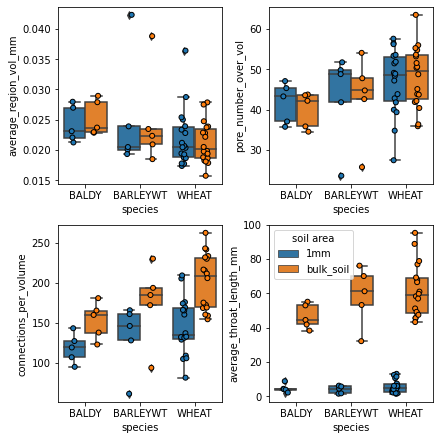

In [78]:
#Plot pore results
porespy_df=region_df_agg.merge(throat_df_agg, on=['IMAGE_ID', "plant", "species","ring"], how='left')
porespy_df["connections_per_volume"]=porespy_df["throat_count"]/(porespy_df["pore_volume"]/1000000000)
porespy_df["average_region_vol_mm"]=porespy_df["average_region_size"]/1000000000
porespy_df["pore_number_over_vol"]=porespy_df["pore_count"]/(porespy_df["pore_volume"]/1000000000)
porespy_df["average_throat_length_mm"]=porespy_df["average_throat_length"]/1000

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(6, 6), constrained_layout=True)
ax1 =sns.boxplot(data=porespy_df, x="species", y="average_region_vol_mm",hue="ring", ax=axs[0,0])
sns.stripplot(x="species", y="average_region_vol_mm", hue="ring", data=porespy_df, dodge=True,ax=ax1,  ec='k', linewidth=1)
ax2 =sns.boxplot(data=porespy_df, x="species", y="pore_number_over_vol",hue="ring" , ax=axs[0,1])
sns.stripplot(x="species", y="pore_number_over_vol", hue="ring", data=porespy_df, dodge=True,ax=ax2,  ec='k', linewidth=1)
ax3 =sns.boxplot(data=porespy_df, x="species", y="connections_per_volume",hue="ring" , ax=axs[1,0])
sns.stripplot(x="species", y="connections_per_volume", hue="ring", data=porespy_df, dodge=True,ax=ax3,  ec='k', linewidth=1)
ax4 =sns.boxplot(data=porespy_df, x="species", y="average_throat_length_mm",hue="ring" , ax=axs[1,1])
sns.stripplot(x="species", y="average_throat_length_mm", hue="ring", data=porespy_df, dodge=True,ax=ax4,  ec='k', linewidth=1)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles[:2], labels[:2], title='soil area', bbox_to_anchor=(0, 1), loc='upper left')
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('porespy_output.png')



In [77]:
porespy_df_table = porespy_df.groupby(["species","ring"],
                                  as_index=False).agg(average_region_vol_mm_mean= ('average_region_vol_mm','mean'),
                                                     pore_number_over_vol_mean= ('pore_number_over_vol','mean'),
                                                     connections_per_volume= ('connections_per_volume','mean'),
                                                     average_throat_length_mm= ('average_throat_length_mm','mean'))
porespy_df_table

,species,ring,average_region_vol_mm_mean,pore_number_over_vol_mean,connections_per_volume,average_throat_length_mm
0,BALDY,1mm,0.024273,41.696183,118.191127,4.586900
1,BALDY,bulk_soil,0.025272,39.977534,153.159730,46.520000
2,BARLEYWT,1mm,0.025225,43.152058,132.242657,3.839800
3,BARLEYWT,bulk_soil,0.024809,42.989802,174.658579,58.553100
4,WHEAT,1mm,0.022078,46.881354,145.432208,5.736083
5,WHEAT,bulk_soil,0.021256,48.148988,200.957844,61.687056


In [ ]:
#Plot the density of pore size # THIS IS SO SLOW  IN PYTHON ??
# rhizo_ring_one_pore_region_size["region_vol_mm"]=rhizo_ring_one_pore_region_size["region_volume"]/1000000000

# fig, ax = plt.subplots()
# sns.displot(data=rhizo_ring_one_pore_region_size, x="region_vol_mm", hue="ring")
# ax.set_xlim(0, 0.025)
# plt.show()

In [ ]:
# Soil Volume 

soil_vol_data_string=(["Rhizosheath_INFO","bulk_soil__INFO"])
soil_vol_data_csv=csv_names[csv_names['csv_text_id'].str.contains('|'.join(soil_vol_data_string))]

soil_vol_df = []

for index, row in soil_vol_data_csv.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info(df_i)
    soil_vol_df.append(df_i)
    
soil_vol_df = pd.concat(soil_vol_df)
soil_vol_df = soil_vol_df.groupby(['IMAGE_ID', "plant", "species","ring"],
              as_index=False).agg(Rhizosheath_Volume_Voxel_Resolved= ('Rhizosheath_Volume_Voxel_Resolved','sum'))
                                            


In [ ]:
# Pore Volume 

pore_data_string=(["Rhizosheath_PORE_INFO","bulk_soil__PORE_INFO"])
pore_data_csv=csv_names[csv_names['csv_text_id'].str.contains('|'.join(pore_data_string))]

pore_data_df = []

for index, row in pore_data_csv.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info(df_i)
    pore_data_df.append(df_i)
    
pore_data_df = pd.concat(pore_data_df)
pore_data_df = pore_data_df.groupby(['IMAGE_ID', "plant", "species","ring"],
              as_index=False).agg(PORE_rhizo_Volume_Voxel_Resolved= ('PORE_rhizo_Volume_Voxel_Resolved','sum'))
                                            


In [ ]:
#Calculate porosity in the rhizosphere and the bulk soil. 
porosity_df=pore_data_df.merge(soil_vol_df, on=['IMAGE_ID', "plant", "species","ring"], how='left')
porosity_df["porosity"]=porosity_df["PORE_rhizo_Volume_Voxel_Resolved"]/porosity_df["Rhizosheath_Volume_Voxel_Resolved"]

plot=sns.boxplot(data=porosity_df, x="species", y="porosity", hue="ring")
sns.stripplot(x="species", y="porosity", hue="ring", data=porosity_df, dodge=True,ax=plot,  ec='k', linewidth=1)
plot.set(title='porosity');
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[:2], labels[:2], title='Soil Area', bbox_to_anchor=(0.05, 0.95), loc='upper left')

plt.savefig('porosity.png')


In [ ]:
porosity_df_table = porosity_df.groupby(["species","ring"],
                                  as_index=False).agg(porosity_mean= ('porosity','mean'))
porosity_df_table

In [ ]:
# TAU-3D
tau_data_string=str("rw_pd")
tau_data_csv=csv_names[csv_names['csv_text_id'].str.contains(tau_data_string)]

tau_data_df = []

for index, row in tau_data_csv.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info(df_i)
    tau_data_df.append(df_i)
    
tau_data_df = pd.concat(tau_data_df)
tau_data_df.rename(columns={'0':'3D_TAU'}, inplace=True)
tau_data_df.rename(columns={'1':'MSD_ID'}, inplace=True)

In [ ]:
tau_data_df_rhizo=tau_data_df.query('ring == "1mm"')
tau_data_df_bulk=tau_data_df.query('ring == "bulk_soil"')

fig, axs = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1 =sns.boxplot(data=tau_data_df_rhizo, x="species", y="3D_TAU", hue="MSD_ID", ax=axs[0])
sns.stripplot(x="species", y="3D_TAU", hue="MSD_ID", data=tau_data_df_rhizo,ax=ax1, dodge=True,  ec='k', linewidth=1)
ax1.set_ylim(0, 15)
ax1.title.set_text('3D Tau in the Rhizosheath')

ax2 =sns.boxplot(data=tau_data_df_bulk, x="species", y="3D_TAU", hue="MSD_ID" , ax=axs[1])
sns.stripplot(x="species", y="3D_TAU", hue="MSD_ID", data=tau_data_df_bulk, dodge=True,ax=ax2,  ec='k', linewidth=1)
ax2.set_ylim(0, 15)
ax2.title.set_text('3D Tau in the Bulk Soil')
ax1.get_legend().remove()

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:4], labels[:4], title='MSD_ID', bbox_to_anchor=(0.5, 1), loc='upper left')

plt.savefig('3D_TAU.png')


In [ ]:
tau_data_df_table = tau_data_df.groupby(["species","ring","MSD_ID"],
                                  as_index=False).agg(TAU_mean= ('3D_TAU','mean'))
tau_data_df_table

In [ ]:
# touching
touching_data_string=str("distance_root_to_air")
touching_data_csv=csv_names[csv_names['csv_text_id'].str.contains(touching_data_string)]

touching_data_df = []

for index, row in touching_data_csv.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), ".tif\\", ".tif" )
    df_i=add_plant_info(df_i)
    touching_data_df.append(df_i)
    
touching_data_df = pd.concat(touching_data_df)

In [ ]:
min_distance= touching_data_df['Distance'].min()
touching_data_df['touching'] = np.where(touching_data_df['Distance']!= min_distance, "Not Touching Air", "Touching Air")
touching_data_df_agg=touching_data_df.groupby(['IMAGE_ID', "plant", "species",'touching']).size().reset_index(name='counts')
#Terrible solution 
touching_data_df_agg_d1=touching_data_df_agg.query('touching== "Touching Air"')
touching_data_df_agg_d1.rename(columns={'counts':'touching_air_counts'}, inplace=True)
touching_data_df_agg_d2=touching_data_df_agg.query('touching== "Not Touching Air"')
touching_data_df_agg_d2.rename(columns={'counts':'not_touching_air_counts'}, inplace=True)
touch_df_sns=touching_data_df_agg_d1.merge(touching_data_df_agg_d2, on=['IMAGE_ID', "plant", "species"], how='left')
touch_df_sns["proportion_touching_air"]=touch_df_sns['touching_air_counts']/(touch_df_sns['touching_air_counts']+touch_df_sns['not_touching_air_counts'])

In [ ]:
plot=sns.boxplot(data=touch_df_sns, x="species", y="proportion_touching_air")
plot.set(title='proportion_touching_air');
plt.savefig('proportion_touching_air.png')